In [1]:
import sqlite3
import pandas as pd
import numpy as np

In [2]:
dd = pd.read_excel('OECD_DataDict.xlsx')
dd.Variable

0             AidDon%GNI
1         AidRec%GNIOECD
2       AidRecGrants%GNI
3    AidRecLoanGross%GNI
4      AidRecLoanNet%GNI
5    AidRecLoanRepay%GNI
6      AidRecRecover%GNI
7    GovTotalOutlays%GDP
8            VaddICT%GDP
Name: Variable, dtype: object

# OECD-Aid

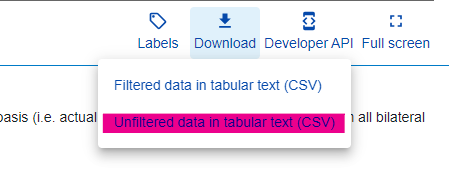

In [3]:
# download the data from OECD based on the wiki page 
# https://pardeewiki.du.edu/index.php?title=OECD_The_Organisation_for_Economic_Co-operation_and_Development
df = pd.read_csv('OECD.DCD.FSD,DSD_DAC2@DF_DAC2A,1.0+all_2.csv')
df = df[df['Measure'].isin([
# 'ODA, total net excluding debt relief',
'Official development assistance (ODA), disbursements',
'ODA grants, disbursements',
'Gross ODA Loans',
'ODA Loans, net disbursements',
'ODA Loans, repayments',
'Recoveries on grants',
# 'ODA as percent of recipient GNI'
])]

In [7]:
# Micronesia stands for region and country, and O8 (in RECIPIENT) is the region name, which needs to be filtered out.
df = df[df['RECIPIENT'] != 'O8']
# df = df[['Donor',
#          'Recipient',
#          'Measure',
#          'Price base', 
#          'TIME_PERIOD',
#          'OBS_VALUE'
#          ]]
df = df[df['Donor'] == 'Official donors']
df = df[df['Price base'] == 'Current prices']
df = df[['Recipient',
         'Measure',
         'TIME_PERIOD',
         'OBS_VALUE'
         ]]

# GNI

In [11]:
country_wdi = pd.read_excel('Country.xlsx',
                            sheet_name= 'WDI')
# download the data from WDI: GNI (Current US$)
gni = pd.read_csv('API_NY.GNP.MKTP.CD_DS2_en_csv_v2_3145.csv')
gni = gni.drop(columns=['Country Code',
                        'Indicator Name',
                        'Indicator Code'])
gni = gni.set_index('Country Name')
gni = pd.DataFrame(gni.stack(dropna = False), 
                  columns = ['gni']).reset_index().rename(columns={'level_1':'year'})
gni = country_wdi.merge(gni, 
                        left_on='Country_WDI',
                        right_on='Country Name',
                        how = 'left')
gni = gni.drop(columns=['Country_WDI','Country Name'])
gni.gni = gni.gni.apply(pd.to_numeric, errors='coerce')
gni.year = gni.year.apply(pd.to_numeric, errors='coerce')
gni


,Country,FIPS_CODE,year,gni
0,Afghanistan,AFG,1960.0,5.488888e+08
1,Afghanistan,AFG,1961.0,5.600000e+08
2,Afghanistan,AFG,1962.0,5.577778e+08
3,Afghanistan,AFG,1963.0,7.666667e+08
4,Afghanistan,AFG,1964.0,8.155556e+08
...,...,...,...,...
11715,Zimbabwe,ZWE,2018.0,3.344290e+10
11716,Zimbabwe,ZWE,2019.0,2.144526e+10
11717,Zimbabwe,ZWE,2020.0,2.107884e+10
11718,Zimbabwe,ZWE,2021.0,2.772683e+10


# OECD Country

In [12]:
country = pd.read_excel('Country.xlsx', sheet_name='OECD')
country

,Country,FIPS_CODE,Recipient
0,Afghanistan,AFG,Afghanistan
1,Albania,ALB,Albania
2,Algeria,DZA,Algeria
3,Angola,AGO,Angola
4,Argentina,ARG,Argentina
...,...,...,...
183,"Venezuela, Bolivarian Republic",VEN,Venezuela
184,Viet Nam,VNM,Viet Nam
185,Yemen,YEM,Yemen
186,Zambia,ZMB,Zambia


# Aid (ODA) disbursements to countries and regions [DAC2A]

## AidRec%GNIOECD - Over

In [13]:
v = 'AidRec%GNIOECD'
m = 'Official development assistance (ODA), disbursements'
dt = df[df['Measure'] == f'{m}']
dt = dt[['Recipient',
        #  'Measure',
         'TIME_PERIOD',
         'OBS_VALUE']]
dt = dt.rename(columns={'TIME_PERIOD': 'year'})
dt = country.merge(dt, on='Recipient', how = 'left' )
dt = dt.drop(columns=['Recipient'])
dt.OBS_VALUE = dt.OBS_VALUE*1000000
dt.OBS_VALUE = dt.OBS_VALUE.apply(pd.to_numeric, errors='coerce')
dt.year = dt.year.apply(pd.to_numeric, errors='coerce')

final = dt.merge(gni, on = ['Country', 'FIPS_CODE','year'], how = 'left')
final['val'] = round(final.OBS_VALUE/final.gni*100,4)
final = final[['Country','FIPS_CODE','year','val']]
# final.val = final.val.apply(lambda x: '%.4f' % x)
first_last = final.sort_values(['Country','year']).groupby(final['Country'])['val'] \
        .agg(['first', 'last']).reset_index()
final.year = final.year.astype('Int64')
first_last = first_last.rename(columns={"first": "Earliest", "last": "MostRecent"})
final = final.pivot_table(index = ['Country','FIPS_CODE'],
                    columns='year',
                    values = 'val').reset_index()
final = final.merge(first_last, on = 'Country', how = 'left')
final = country.merge(final, on = ['Country','FIPS_CODE'], how = 'left')
final = final.drop(columns=['Recipient'])
# final.to_csv(f'IFs Import/{v}.csv', index = False)

# final.sort_values(by = 'val', ascending=False).head(20)
final.drop(columns=['FIPS_CODE','Earliest','MostRecent'], inplace=True)
final = final.set_index('Country')
final = pd.DataFrame(final.stack(dropna = False), 
                  columns = ['val']).reset_index().rename(columns={'level_1':'year'})
final[final['val'] > 100].sort_values(by = ['Country','year'])

,Country,year,val
4882,Iraq,1991,1.375877e+02
10330,Syrian Arab Republic,2021,1.132506e+02
11685,Yemen,1990,3.580453e+06
11686,Yemen,1991,2.089937e+06
11687,Yemen,1992,1.446631e+06
11688,Yemen,1993,1.470974e+06
11689,Yemen,1994,6.246454e+05
11690,Yemen,1995,1.403522e+06
11691,Yemen,1996,4.256823e+06
11692,Yemen,1997,5.709425e+06


## ODA as percent of recipient GNI: the calculation is off for Yemen, ODA is in million, GNI is in value. They didn't convert the number into million but divide them directly.

In [ ]:
# v = 'AidRec%GNIOECD'
# m = 'ODA as percent of recipient GNI'
# dt = df[df['Measure'] == f'{m}']
# dt = dt[['Recipient',
#         #  'Measure',
#          'TIME_PERIOD',
#          'OBS_VALUE']]
# dt = dt.rename(columns={'TIME_PERIOD': 'year'})
# first_last = dt.sort_values(['Recipient','year']).groupby(dt['Recipient'])['OBS_VALUE'] \
#         .agg(['first', 'last']).reset_index()
# final.year = final.year.astype('Int64')
# first_last = first_last.rename(columns={"first": "Earliest", "last": "MostRecent"})
# dt = dt.pivot_table(index = ['Recipient'],
#                     columns='year',
#                     values = 'OBS_VALUE').reset_index()
# dt = dt.merge(first_last, on = 'Recipient', how = 'left')
# dt = country.merge(dt, on = 'Recipient', how = 'left')
# dt = dt.drop(columns=['Recipient'])
# dt.to_csv(f'IFs Import/{v}.csv', index = False)
# dt

## AidRecGrants%GNI - Over

In [14]:
v = 'AidRecGrants%GNI'
m = 'ODA grants, disbursements'
dt = df[df['Measure'] == f'{m}']
dt = dt[['Recipient',
        #  'Measure',
         'TIME_PERIOD',
         'OBS_VALUE']]
dt = dt.rename(columns={'TIME_PERIOD': 'year'})
dt = country.merge(dt, on='Recipient', how = 'left' )
dt = dt.drop(columns=['Recipient'])
dt.OBS_VALUE = dt.OBS_VALUE*1000000
dt.OBS_VALUE = dt.OBS_VALUE.apply(pd.to_numeric, errors='coerce')
dt.year = dt.year.apply(pd.to_numeric, errors='coerce')

final = dt.merge(gni, on = ['Country', 'FIPS_CODE','year'], how = 'outer')
final['val'] = round(final.OBS_VALUE/final.gni*100,4)
print(final.val.max())
final = final[['Country','FIPS_CODE','year','val']]
# final.val = final.val.apply(lambda x: '%.4f' % x)
first_last = final.sort_values(['Country','year']).groupby(final['Country'])['val'] \
        .agg(['first', 'last']).reset_index()
final.year = final.year.astype('Int64')
first_last = first_last.rename(columns={"first": "Earliest", "last": "MostRecent"})
final = final.pivot_table(index = ['Country','FIPS_CODE'],
                    columns='year',
                    values = 'val').reset_index()
final = final.merge(first_last, on = 'Country', how = 'left')
final = country.merge(final, on = ['Country','FIPS_CODE'], how = 'left')
final = final.drop(columns=['Recipient'])
# final.to_csv(f'IFs Import/{v}.csv', index = False)

# final.sort_values(by = 'val', ascending=False).head(20)
final.drop(columns=['FIPS_CODE','Earliest','MostRecent'], inplace=True)
final = final.set_index('Country')
final = pd.DataFrame(final.stack(dropna = False), 
                  columns = ['val']).reset_index().rename(columns={'level_1':'year'})
final[final['val'] > 100].sort_values(by = ['Country','year'])


37430118.5756


,Country,year,val
4882,Iraq,1991,1.376076e+02
8993,Sao Tome and Principe,2007,1.077844e+02
10330,Syrian Arab Republic,2021,1.133576e+02
11685,Yemen,1990,3.097148e+06
11686,Yemen,1991,1.204032e+06
11687,Yemen,1992,1.091658e+06
11688,Yemen,1993,9.042265e+05
11689,Yemen,1994,5.116126e+05
11690,Yemen,1995,1.303439e+06
11691,Yemen,1996,2.939802e+06


## AidRecLoanGross%GNI - Over

In [15]:
v = 'AidRecLoanGross%GNI'
m = 'Gross ODA Loans'
dt = df[df['Measure'] == f'{m}']
dt = dt[['Recipient',
        #  'Measure',
         'TIME_PERIOD',
         'OBS_VALUE']]
dt = dt.rename(columns={'TIME_PERIOD': 'year'})
dt = country.merge(dt, on='Recipient', how = 'left' )
dt = dt.drop(columns=['Recipient'])
dt.OBS_VALUE = dt.OBS_VALUE*1000000
dt.OBS_VALUE = dt.OBS_VALUE.apply(pd.to_numeric, errors='coerce')
dt.year = dt.year.apply(pd.to_numeric, errors='coerce')

final = dt.merge(gni, on = ['Country', 'FIPS_CODE','year'], how = 'left')
final['val'] = round(final.OBS_VALUE/final.gni*100,4)
final = final[['Country','FIPS_CODE','year','val']]
# final.val = final.val.apply(lambda x: '%.4f' % x)
first_last = final.sort_values(['Country','year']).groupby(final['Country'])['val'] \
        .agg(['first', 'last']).reset_index()
final.year = final.year.astype('Int64')
first_last = first_last.rename(columns={"first": "Earliest", "last": "MostRecent"})
final = final.pivot_table(index = ['Country','FIPS_CODE'],
                    columns='year',
                    values = 'val').reset_index()
final = final.merge(first_last, on = 'Country', how = 'left')
final = country.merge(final, on = ['Country','FIPS_CODE'], how = 'left')
final = final.drop(columns=['Recipient'])
# final.to_csv(f'IFs Import/{v}.csv', index = False)

# final.sort_values(by = 'val', ascending=False).head(20)
final.drop(columns=['FIPS_CODE','Earliest','MostRecent'], inplace=True)
final = final.set_index('Country')
final = pd.DataFrame(final.stack(dropna = False), 
                  columns = ['val']).reset_index().rename(columns={'level_1':'year'})
final[final['val'] > 100].sort_values(by = ['Country','year'])

,Country,year,val
11685,Yemen,1990,1.033550e+06
11686,Yemen,1991,1.363414e+06
11687,Yemen,1992,6.434224e+05
11688,Yemen,1993,7.751049e+05
11689,Yemen,1994,2.923865e+05
11690,Yemen,1995,3.977965e+05
11691,Yemen,1996,1.741067e+06
11692,Yemen,1997,2.887645e+06
11693,Yemen,1998,3.853932e+06
11694,Yemen,1999,4.060356e+06


## AidRecLoanNet%GNI - Over

In [16]:
v = 'AidRecLoanNet%GNI'
m = 'ODA Loans, net disbursements'
dt = df[df['Measure'] == f'{m}']
dt = dt[['Recipient',
        #  'Measure',
         'TIME_PERIOD',
         'OBS_VALUE']]
dt = dt.rename(columns={'TIME_PERIOD': 'year'})
dt = country.merge(dt, on='Recipient', how = 'left' )
dt = dt.drop(columns=['Recipient'])
dt.OBS_VALUE = dt.OBS_VALUE*1000000
dt.OBS_VALUE = dt.OBS_VALUE.apply(pd.to_numeric, errors='coerce')
dt.year = dt.year.apply(pd.to_numeric, errors='coerce')

final = dt.merge(gni, on = ['Country', 'FIPS_CODE','year'], how = 'left')
final['val'] = round(final.OBS_VALUE/final.gni*100,4)
final = final[['Country','FIPS_CODE','year','val']]
# final.val = final.val.apply(lambda x: '%.4f' % x)
first_last = final.sort_values(['Country','year']).groupby(final['Country'])['val'] \
        .agg(['first', 'last']).reset_index()
final.year = final.year.astype('Int64')
first_last = first_last.rename(columns={"first": "Earliest", "last": "MostRecent"})
final = final.pivot_table(index = ['Country','FIPS_CODE'],
                    columns='year',
                    values = 'val').reset_index()
final = final.merge(first_last, on = 'Country', how = 'left')
final = country.merge(final, on = ['Country','FIPS_CODE'], how = 'left')
final = final.drop(columns=['Recipient'])
# final.to_csv(f'IFs Import/{v}.csv', index = False)

# final.sort_values(by = 'val', ascending=False).head(20)
final.drop(columns=['FIPS_CODE','Earliest','MostRecent'], inplace=True)
final = final.set_index('Country')
final = pd.DataFrame(final.stack(dropna = False), 
                  columns = ['val']).reset_index().rename(columns={'level_1':'year'})
final[final['val'] > 100].sort_values(by = ['Country','year'])

,Country,year,val
11685,Yemen,1990,4.833051e+05
11686,Yemen,1991,8.859050e+05
11687,Yemen,1992,3.550310e+05
11688,Yemen,1993,5.667943e+05
11689,Yemen,1994,1.130328e+05
11690,Yemen,1995,1.000823e+05
11691,Yemen,1996,1.317190e+06
11692,Yemen,1997,2.538236e+06
11693,Yemen,1998,3.135888e+06
11694,Yemen,1999,3.618519e+06


## AidRecLoanRepay%GNI - Over

In [17]:
v = 'AidRecLoanRepay%GNI'
m = 'ODA Loans, repayments'
dt = df[df['Measure'] == f'{m}']
dt = dt[['Recipient',
        #  'Measure',
         'TIME_PERIOD',
         'OBS_VALUE']]
dt = dt.rename(columns={'TIME_PERIOD': 'year'})
dt = country.merge(dt, on='Recipient', how = 'left' )
dt = dt.drop(columns=['Recipient'])
dt.OBS_VALUE = dt.OBS_VALUE*1000000
dt.OBS_VALUE = dt.OBS_VALUE.apply(pd.to_numeric, errors='coerce')
dt.year = dt.year.apply(pd.to_numeric, errors='coerce')

final = dt.merge(gni, on = ['Country', 'FIPS_CODE','year'], how = 'left')
final['val'] = round(final.OBS_VALUE/final.gni*100,4)
final = final[['Country','FIPS_CODE','year','val']]
# final.val = final.val.apply(lambda x: '%.4f' % x)
first_last = final.sort_values(['Country','year']).groupby(final['Country'])['val'] \
        .agg(['first', 'last']).reset_index()
final.year = final.year.astype('Int64')
first_last = first_last.rename(columns={"first": "Earliest", "last": "MostRecent"})
final = final.pivot_table(index = ['Country','FIPS_CODE'],
                    columns='year',
                    values = 'val').reset_index()
final = final.merge(first_last, on = 'Country', how = 'left')
final = country.merge(final, on = ['Country','FIPS_CODE'], how = 'left')
final = final.drop(columns=['Recipient'])
# final.to_csv(f'IFs Import/{v}.csv', index = False)

# final.sort_values(by = 'val', ascending=False).head(20)
final.drop(columns=['FIPS_CODE','Earliest','MostRecent'], inplace=True)
final = final.set_index('Country')
final = pd.DataFrame(final.stack(dropna = False), 
                  columns = ['val']).reset_index().rename(columns={'level_1':'year'})
final[final['val'] < -100].sort_values(by = ['Country','year'])

,Country,year,val
11685,Yemen,1990,-5.502450e+05
11686,Yemen,1991,-4.775086e+05
11687,Yemen,1992,-2.883914e+05
11688,Yemen,1993,-2.083106e+05
11689,Yemen,1994,-1.793536e+05
11690,Yemen,1995,-2.977142e+05
11691,Yemen,1996,-4.238768e+05
11692,Yemen,1997,-2.882023e+05
11693,Yemen,1998,-7.046317e+05
11694,Yemen,1999,-4.264282e+05


## AidRecRecover%GNI - Over

In [18]:
v = 'AidRecRecover%GNI'
m = 'Recoveries on grants'
dt = df[df['Measure'] == f'{m}']
dt = dt[['Recipient',
        #  'Measure',
         'TIME_PERIOD',
         'OBS_VALUE']]
dt = dt.rename(columns={'TIME_PERIOD': 'year'})
dt = country.merge(dt, on='Recipient', how = 'left' )
dt = dt.drop(columns=['Recipient'])
dt.OBS_VALUE = dt.OBS_VALUE*1000000
dt.OBS_VALUE = dt.OBS_VALUE.apply(pd.to_numeric, errors='coerce')
dt.year = dt.year.apply(pd.to_numeric, errors='coerce')

final = dt.merge(gni, on = ['Country', 'FIPS_CODE','year'], how = 'left')
final['val'] = round(final.OBS_VALUE/final.gni*100,4)
final = final[['Country','FIPS_CODE','year','val']]
# final.val = final.val.apply(lambda x: '%.4f' % x)
first_last = final.sort_values(['Country','year']).groupby(final['Country'])['val'] \
        .agg(['first', 'last']).reset_index()
final.year = final.year.astype('Int64')
first_last = first_last.rename(columns={"first": "Earliest", "last": "MostRecent"})
final = final.pivot_table(index = ['Country','FIPS_CODE'],
                    columns='year',
                    values = 'val').reset_index()
final = final.merge(first_last, on = 'Country', how = 'left')
final = country.merge(final, on = ['Country','FIPS_CODE'], how = 'left')
final = final.drop(columns=['Recipient'])
# final.to_csv(f'IFs Import/{v}.csv', index = False)

# final.sort_values(by = 'val', ascending=False).head(20)
final.drop(columns=['FIPS_CODE','Earliest','MostRecent'], inplace=True)
final = final.set_index('Country')
final = pd.DataFrame(final.stack(dropna = False), 
                  columns = ['val']).reset_index().rename(columns={'level_1':'year'})
final[final['val'] < -100].sort_values(by = ['Country','year'])

,Country,year,val
3518,Yemen,2007,-344.8217
3519,Yemen,2008,-160.0286
3520,Yemen,2009,-834.7886
3521,Yemen,2010,-1925.2080
3522,Yemen,2011,-2171.8390
3523,Yemen,2012,-945.8588
3524,Yemen,2013,-2746.1401
3525,Yemen,2014,-4512.1772
3526,Yemen,2015,-5066.1353
3527,Yemen,2016,-28514.3187


# Flows by donor (ODA+OOF+Private) [DAC1]

## AidDon%GNI

In [107]:
v = 'AidDon%GNI'
# download the data from OECD based on the wiki page 
# https://pardeewiki.du.edu/index.php?title=OECD_The_Organisation_for_Economic_Co-operation_and_Development

dt = pd.read_csv('ODA by Donor.csv')
# for c in dt.columns:
#     print(c,dt[c].unique())
dt = dt[['Donor',
        #  'Measure',
         'TIME_PERIOD',
         'OBS_VALUE']]
dt = dt.rename(columns={'TIME_PERIOD': 'year'})
# print(dt[dt['OBS_VALUE'] > 1])
# dt['Donor'].to_csv('Donor_Only.csv', index = False)
country_don = pd.read_excel('Country.xlsx', sheet_name='Donor')
# # dt = country_don.merge(dt, on='Donor', how = 'left' )
# # dt = dt.drop(columns=['Donor'])
first_last = dt.sort_values(['Donor','year']).groupby(dt['Donor'])['OBS_VALUE'] \
        .agg(['first', 'last']).reset_index()
first_last = first_last.rename(columns={"first": "Earliest", "last": "MostRecent"})
dt = dt.pivot_table(index = ['Donor'],
                    columns='year',
                    values = 'OBS_VALUE').reset_index()
dt = dt.merge(first_last, on = 'Donor', how = 'left')
dt = country_don.merge(dt, on = 'Donor', how = 'left')
dt = dt.drop(columns=['Donor'])
# dt.to_csv(f'IFs Import/{v}.csv', index = False)
dt

,Country,FIPS_CODE,1960,1961,1962,1963,1964,1965,1966,1967,...,2015,2016,2017,2018,2019,2020,2021,2022,Earliest,MostRecent
0,Afghanistan,AFG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Albania,ALB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Algeria,DZA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Angola,AGO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Argentina,ARG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183,"Venezuela, Bolivarian Republic",VEN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
184,Viet Nam,VNM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
185,Yemen,YEM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
186,Zambia,ZMB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# GovTotalOutlays%GDP

In [29]:
country_gov = pd.read_excel('Country.xlsx', sheet_name='Gov')
# download the data based on the wiki page 
# https://pardeewiki.du.edu/index.php?title=OECD_The_Organisation_for_Economic_Co-operation_and_Development
dt = pd.read_excel('EO114_Statistical_Annexes.xlsx', 
                   sheet_name='Total_Outlays',
                   skiprows=2,
                   nrows=37)
dt = dt.dropna(how='all',axis = 1)
dt = dt.drop(columns='Average')
dt = dt.rename(columns={'Unnamed: 0':'Recipient'})
dt = dt.dropna(axis=0, how = 'all')
v = 'GovTotalOutlays%GDP'
# dt['Recipient'].to_csv('Gov.csv', index = False)
dt = dt.set_index('Recipient')
dt = pd.DataFrame(dt.stack(dropna = False), 
                  columns = ['val']).reset_index().rename(columns={'level_1':'Year'})

dt.Year = dt.Year.apply(pd.to_numeric, errors='coerce')
dt.val = dt.val.apply(pd.to_numeric, errors='coerce')
dt.val = round(dt.val,3)
dt = country_gov.merge(dt, on = 'Recipient', how = 'left')
dt = dt.drop(columns=['Recipient'])
dt.dtypes

# connect to database
con = sqlite3.connect(r"C:\Users\Public\IFs\DATA\IFsHistSeries.db")
sql_query = """SELECT name FROM sqlite_master  
  WHERE type='table';"""
# create cursor object
cursor = con.cursor()
# execute the above SQL query
cursor.execute(sql_query)
# print a list of all tables which are present in database
# print(cursor.fetchall())

v = 'GovTotalOutlays%GDP'
tbname = 'Series'+ f'{v}'
# use pands read sql table into dataframe
dt_ifs = pd.read_sql_query(f"SELECT * FROM '{tbname}'", con)
# col = dt_ifs.columns[dt_ifs.dtypes.eq('float64')]

dt_ifs = dt_ifs.drop(columns=['Earliest','MostRecent'])
dt_ifs = dt_ifs.melt(id_vars= ["Country","FIPS_CODE"],var_name="Year",value_name="val")
dt_ifs.Year = dt_ifs.Year.apply(pd.to_numeric, errors='coerce')
dt_ifs.dtypes
dt_ifs = dt_ifs[dt_ifs['Year'] < 2010]
dt_ifs

dt = pd.concat([dt, dt_ifs], ignore_index= True)
dt.Year = dt.Year.astype("Int64")
first_last = dt.sort_values(['Country','Year']).groupby(dt['Country'])['val'] \
        .agg(['first', 'last']).reset_index()
first_last = first_last.rename(columns={"first": "Earliest", "last": "MostRecent"})

dt = dt.pivot_table(index = ["Country","FIPS_CODE"],
                    columns='Year',
                    values = 'val').reset_index()
dt = dt.merge(first_last, on = 'Country', how = 'left')
dt = country_gov.merge(dt, on = ["Country","FIPS_CODE"], how = 'left')
dt = dt.drop(columns=['Recipient'])

# dt.to_csv(f'IFs Import/{v}.csv', index = False)
dt

,Country,FIPS_CODE,1993,1994,1995,1996,1997,1998,1999,2000,...,2018,2019,2020,2021,2022,2023,2024,2025,Earliest,MostRecent
0,Afghanistan,AFG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Albania,ALB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Algeria,DZA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Angola,AGO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Argentina,ARG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183,"Venezuela, Bolivarian Republic",VEN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
184,Viet Nam,VNM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
185,Yemen,YEM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
186,Zambia,ZMB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# VaddICT%GDP

In [29]:
v = 'VaddICT%GDP'
# download the data from OECD based on the wiki page 
# https://pardeewiki.du.edu/index.php?title=OECD_The_Organisation_for_Economic_Co-operation_and_Development
dt = pd.read_csv('ICT Value Added.csv')
# for c in dt.columns:
#     print(c,dt[c].unique())
dt = dt[['Reference area',
        #  'Measure',
         'TIME_PERIOD',
         'OBS_VALUE']]
dt = dt.rename(columns={'TIME_PERIOD': 'year'})
# Two dvisions to be added
dt = dt.groupby(['Reference area','year']).sum().reset_index()
# dt['Reference area'].to_csv('ICT_Only.csv', index = False)
country_ict = pd.read_excel('Country.xlsx', sheet_name='ICT')
dt = country_ict.merge(dt, on='Reference area', how = 'left' )
dt = dt.drop(columns=['Reference area'])
dt.OBS_VALUE = dt.OBS_VALUE*1000000
dt.OBS_VALUE = dt.OBS_VALUE.apply(pd.to_numeric, errors='coerce')
dt.year = dt.year.apply(pd.to_numeric, errors='coerce')

gdp = pd.read_excel('API_NY.GDP.MKTP.CN_DS2_en_excel_v2_70.xls', 
                    sheet_name='Data',
                    skiprows=3)
gdp = gdp.drop(columns=['Country Code',
                        'Indicator Name',
                        'Indicator Code'])
country_wdi = pd.read_excel('Country.xlsx',
                            sheet_name= 'WDI')
# for x in gdp['Country Name'].unique():
#     if x not in country_wdi.Country_WDI.unique():
#         print(x)
gdp = gdp.set_index('Country Name')
gdp = pd.DataFrame(gdp.stack(dropna = False), 
                  columns = ['gdp']).reset_index().rename(columns={'level_1':'year'})
gdp = country_wdi.merge(gdp, 
                        left_on='Country_WDI',
                        right_on='Country Name',
                        how = 'left')
gdp = gdp.drop(columns=['Country_WDI','Country Name'])
gdp.gdp = gdp.gdp.apply(pd.to_numeric, errors='coerce')
gdp.year = gdp.year.apply(pd.to_numeric, errors='coerce')

final = dt.merge(gdp, on = ['Country', 'FIPS_CODE','year'], how = 'outer')
final['val'] = round(final.OBS_VALUE/final.gdp*100,2)
print(final.val.max())
final = final[['Country','FIPS_CODE','year','val']]
final.val = round(final.val, 2)
# final.val = final.val.apply(lambda x: '%.4f' % x)
first_last = final.sort_values(['Country','year']).groupby(final['Country'])['val'] \
        .agg(['first', 'last']).reset_index()
final.year = final.year.astype('Int64')
first_last = first_last.rename(columns={"first": "Earliest", "last": "MostRecent"})
final = final.pivot_table(index = ['Country','FIPS_CODE'],
                    columns='year',
                    values = 'val').reset_index()
final = final.merge(first_last, on = 'Country', how = 'left')
final = country_ict.merge(final, on = ['Country','FIPS_CODE'], how = 'left')
final = final.drop(columns=['Reference area'])
# final.to_csv(f'IFs Import/{v}.csv', index = False)
final

16.7


,Country,FIPS_CODE,1960,1961,1962,1963,1964,1965,1966,1967,...,2015,2016,2017,2018,2019,2020,2021,2022,Earliest,MostRecent
0,Afghanistan,AFG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Albania,ALB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.97,3.08,3.09,NaN,NaN,NaN,NaN,NaN,1.28,3.09
2,Algeria,DZA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Angola,AGO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Argentina,ARG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183,"Venezuela, Bolivarian Republic",VEN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
184,Viet Nam,VNM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
185,Yemen,YEM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
186,Zambia,ZMB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
